In [1]:
import imp
import numpy as np
from tqdm import tqdm
import os

import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.utils as vutils

from model.Generator import Generator
from model.Discriminator import Discriminator

IMAGE_DIR = 'Data'
IMAGE_SIZE = 64
IMAGE_CHANNEL = 3

BATCH_SIZE = 32


/var/folders/mq/vysn21h93d95l3tsbt8txq400000gn/T/ipykernel_36581/1560000665.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp


( to del .DS_Store in this dir and subdirs )

find . -name ".DS_Store" -delete

### Problem of image

in collecting images for training GAN, we do
1. resize the smallest dim into IMAGE_SIZE
2. center crop into (IMAGE_SIZE, IMAGE_SIZE)

but some original object in image is not center places, thus some part of object will be cut

In [ ]:
resize = transforms.Resize(IMAGE_SIZE)
crop = transforms.CenterCrop(IMAGE_SIZE)

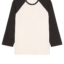

In [70]:
image = "Data/REVOLVE/JOHF-MS143_V1.jpg"
pil_image = Image.open(image)
crop(resize(pil_image))

### Preprocess Function

- target image will be square
- different data source may need different background threshold  ( too low may let the white T-shit be elimunated )

In [123]:
def crop_image(image_path):
    image = cv2.imread(image_path)
    ## (1) Convert to gray, and threshold
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    th, threshed = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY_INV)

    ## (2) Morph-op to remove noise
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)

    ## (3) Find the max-area contour
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    ## (4) produce square bounding box with extension (10% of both side)
    x,y,w,h = cv2.boundingRect(cnt)
    dst = image[y:y+h, x:x+w]
    target_size = max(w,h) * 1.2
    top_bottom_pad = round((target_size - h)/2)
    left_right_pad = round((target_size - w)/2)
    dst = cv2.copyMakeBorder(dst, top_bottom_pad, top_bottom_pad, left_right_pad, left_right_pad, cv2.BORDER_CONSTANT, value = (255,255,255))

    return dst

In [126]:
# brand_list =  ['ABCmart','covernat','FWRD','Hopes','KIKS','lativ','muji','plainme','REMIX','REVOLVE','roots','thisisneverthat','ZARA']
brand_list = ['Beams']
for brand in brand_list:
    print(f'Processing {brand}')
    source_image_dir = f'Data/{brand}'
    target_image_dir = f'Preprocessed_Data/{brand}'
    if not os.path.exists(target_image_dir): os.mkdir(target_image_dir)

    for file_name in tqdm(os.listdir(source_image_dir)):
        if file_name[0] == '.':
            continue
        result_image = crop_image(f"{source_image_dir}/{file_name}")
        cv2.imwrite(f"{target_image_dir}/{file_name}",result_image)

Processing Beams


100%|██████████| 55/55 [00:00<00:00, 411.79it/s]


### check the processed image

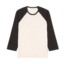

In [95]:
image = "Preprocessed_Data/REVOLVE/JOHF-MS143_V1.jpg"
pil_image = Image.open(image)
crop(resize(pil_image))

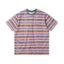

In [107]:
image = "Preprocessed_Data/thisisneverthat/5bf9e42b7a8aa3e3cccd5838a0270184_tn.jpeg"
pil_image = Image.open(image)
crop(resize(pil_image))